


**Identificando fraudes em transações com cartão de crédito utilizando Data Science e Machine Learning** 
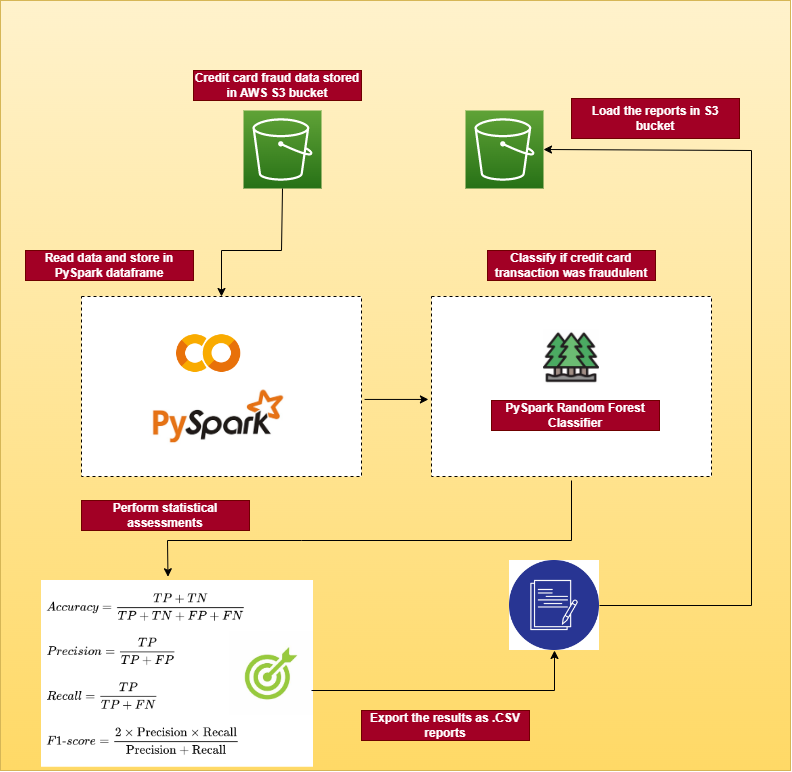



**Instalando Pyspark** 

In [ ]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317145 sha256=e6ebbdbc586e51e2fc5a7e86f93d0ef873bf4ecca679e06e47912b0a3cabc555
  Stored in directory: /root/.cache/pip/wheels/9f/34/a4/159aa12d0a510d5ff7c8f0220abbea42e5d81ecf588c4fd884
Successfully built pyspark


**Instalando Boto3**

In [ ]:
!pip install boto3

**Importando bibliotecas**

In [ ]:
from pyspark.sql import SparkSession
#import boto3
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyspark.ml import PipelineModel



**Criando Sessão PySpark**

In [ ]:
# Create a SparkSession
spark = SparkSession.builder \
    .appName("Read CSV from S3") \
    .getOrCreate()

**Definindo conexão com AWS S3 através de credenciais do cliente**

In [ ]:
# estabelecer a conexão com o S3
s3 = boto3.client('s3', aws_access_key_id='YOUR_ACCESS_KEY', aws_secret_access_key='YOUR_SECRET_KEY')

**Definindo informações sobre o bucket S3 e importando os dados para um data frame do Spark**

In [ ]:
# Read the CSV file from S3
s3_bucket_name = "your-s3-bucket-name"
s3_csv_file_path = "s3a://{}/path/to/your/file.csv".format(s3_bucket_name)
df = spark.read.format("csv") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load(s3_csv_file_path)

# Show the DataFrame
df.show()


In [ ]:
df = spark.read.csv("card_transdata.csv", header=True, inferSchema=True)
df.show()

+------------------+------------------------------+------------------------------+---------------+---------+---------------+------------+-----+
|distance_from_home|distance_from_last_transaction|ratio_to_median_purchase_price|repeat_retailer|used_chip|used_pin_number|online_order|fraud|
+------------------+------------------------------+------------------------------+---------------+---------+---------------+------------+-----+
| 57.87785658389723|            0.3111400080477545|            1.9459399775518593|            1.0|      1.0|            0.0|         0.0|  0.0|
|10.829942699255545|           0.17559150228166587|            1.2942188106198573|            1.0|      0.0|            0.0|         0.0|  0.0|
| 5.091079490616996|            0.8051525945853258|           0.42771456119427587|            1.0|      0.0|            0.0|         1.0|  0.0|
|2.2475643282963613|              5.60004354707232|           0.36266257805709584|            1.0|      1.0|            0.0|         1.0

**Definindo quais serão nossas features e qual será nosso target**

In [ ]:
list_col=["distance_from_home","distance_from_last_transaction","ratio_to_median_purchase_price","repeat_retailer","used_chip","used_pin_number","online_order"]
assembler = VectorAssembler(inputCols=list_col, outputCol="features")
df = assembler.transform(df)
train_data, test_data = df.randomSplit([0.7, 0.3], seed=12345)


**Instanciando o modelo Random Forest Classifier**

In [ ]:

rf = RandomForestClassifier(numTrees=10, maxDepth=5, labelCol="fraud", featuresCol="features")


**Aplicando o fit nos dados de treinamento**

In [ ]:
model = rf.fit(train_data)


**Realizando predições**

In [ ]:
predictions = model.transform(test_data)


**Gerando matriz de confusão com Matplotlib**

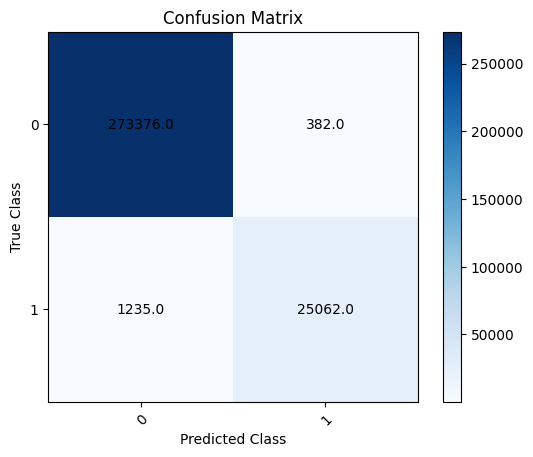

In [ ]:
# Convert the predictions and actual labels to RDDs
predictions_and_labels = predictions.select("prediction", "fraud").rdd

# Instantiate a MulticlassMetrics object
metrics = MulticlassMetrics(predictions_and_labels)

# Get the confusion matrix
confusion_matrix = metrics.confusionMatrix().toArray()

# Get the class labels
labels = [str(i) for i in range(len(confusion_matrix))]

# Create a heatmap of the confusion matrix
fig, ax = plt.subplots()
im = ax.imshow(confusion_matrix, cmap='Blues')

# Set the colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Set the axis ticks and labels
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

# Rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations
for i in range(len(labels)):
    for j in range(len(labels)):
        ax.text(j, i, confusion_matrix[i, j],
                ha="center", va="center", color="black")

# Set the plot title and labels
ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted Class")
ax.set_ylabel("True Class")

# Display the plot
plt.show()

**Calculando métricas gerais para avaliação do classificador**

In [ ]:
# Evaluate the model using MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="fraud", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy = {}".format(accuracy))

evaluator = MulticlassClassificationEvaluator(labelCol="fraud", predictionCol="prediction", metricName="weightedPrecision")
precision = evaluator.evaluate(predictions)
print("Precision = {}".format(precision))

evaluator = MulticlassClassificationEvaluator(labelCol="fraud", predictionCol="prediction", metricName="weightedRecall")
recall = evaluator.evaluate(predictions)
print("Recall = {}".format(recall))

evaluator = MulticlassClassificationEvaluator(labelCol="fraud", predictionCol="prediction", metricName="f1")
f1_score = evaluator.evaluate(predictions)
print("F1 Score = {}".format(f1_score))

Accuracy = 0.9946109879855359
Precision = 0.9945810927114329
Recall = 0.9946109879855359
F1 Score = 0.994570757833375


**Salvado os resultados resumidos em arquivos .CSV**

In [ ]:
# Evaluate the model using MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="fraud", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

# Compute the confusion matrix
confusion_matrix = predictions.groupBy('fraud').pivot('prediction', [0, 1]).count().fillna(0).toPandas()

# Compute the classification metrics
metrics = pd.DataFrame({'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
                        'Value': [accuracy, precision, recall, f1_score]})

# Export the confusion matrix and metrics to CSV files
confusion_matrix.to_csv('confusion_matrix.csv', index=False)
metrics.to_csv('classification_metrics.csv', index=False)

**Salvado os mesmos arquivos em um bucket S3**

In [ ]:
bucket_name = 'your-bucket-name'
file_name = 'your-file-name.csv'

with open(file_name, 'rb') as data:
    file_contents = data.read()

s3.put_object(Body=file_contents, Bucket=bucket_name, Key=file_name)


**Salvando o modelo RF em um bucket S3**

In [ ]:
model.save("s3a://your-bucket/path_to_save_model")


**Carregando o modelo do bucket S3**

In [ ]:
loaded_model = PipelineModel.load("s3a://your-bucket/path_to_saved_model")


**Bônus: Treinando modelos utilizando k-folds cross validation**

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline

# Load data
data = spark.read.format("libsvm").load("data/mllib/sample_libsvm_data.txt")

# Create random forest classifier
rf = RandomForestClassifier(numTrees=10)

# Define grid of hyperparameters to search
paramGrid = ParamGridBuilder() \
    .addGrid(rf.maxDepth, [2, 5, 10]) \
    .addGrid(rf.minInstancesPerNode, [1, 5, 10]) \
    .build()

# Set up evaluation metric
evaluator = BinaryClassificationEvaluator()

# Set up cross-validator
cv = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

# Define pipeline
pipeline = Pipeline(stages=[cv])

# Fit model
model = pipeline.fit(data)

# Get best model
bestModel = model.stages[0].bestModel
